# Import necessary libraries

In [1]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import os
import time
from matplotlib import pyplot as plt
from scipy.fftpack import dct
from skimage.feature import greycomatrix
from skimage import io, color
import warnings

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

C:\Users\Magda\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Suppress RuntimeWarnings

In [2]:
#sets up a filter to ignore warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define the desired dimensions

In [3]:
new_width = 100  
new_height = 100  

# Initialize a list to store feature vectors

In [4]:
list_of_histogram_features = []

# 1. Traditional Feature Extraction (3+ Features):

# Define functions

## 1. 1 Color Histograms

Histogram feature extraction is a technique used in image processing and computer vision to represent the distribution of pixel intensities in an image. It provides a statistical representation of the image content, offering valuable insights into the image characteristics. Here's an overview of histogram feature extraction, along with its pros and cons:

#### Histogram Feature Extraction:
In summary, histogram feature extraction is a valuable and widely used technique for image analysis, providing a quick and intuitive overview of pixel intensity distributions. However, its limitations, such as the loss of spatial information and sensitivity to lighting changes, should be considered when choosing it for specific applications. It is often used in conjunction with other feature extraction methods to enhance the overall representation of image content.

### Function: calculate_histogram

In [5]:
def calculate_histogram(image):
    """
    Calculate color histograms for an image.
    resizes the input image using the cv2.resize function
    These lines calculate the color histograms for each channel (blue, green, and red) of the resized image
    using the cv2.calcHist function. The parameters for calcHist are:

    [resized_image]: List of images for which the histogram will be calculated.
    [0], [1], [2]: Channels for which the histogram will be calculated (0 for blue, 1 for green, 2 for red).
    None: No mask is used here.
    [256]: Number of bins for the histogram.
    [0, 256]: Range of pixel values to consider.
    returns the calculated histograms for blue, green, and red channels.
    """
    resized_image = cv2.resize(image, (new_width, new_height))
    hist_b = cv2.calcHist([resized_image], [0], None, [256], [0,256])
    hist_g = cv2.calcHist([resized_image], [1], None, [256], [0,256])
    hist_r = cv2.calcHist([resized_image], [2], None, [256], [0,256])
    return hist_b, hist_g, hist_r


### Function: concatenate_histograms

In [6]:
def concatenate_histograms(hist_b, hist_g, hist_r):
    """
    Concatenate the histograms into a single vector.
    This function, named concatenate_histograms, 
    takes three histograms corresponding to the blue, 
    green, and red channels and concatenates them into a single vector.
    """
    return np.concatenate((hist_b, hist_g, hist_r), axis=None)

### Function: normalize_with_pca

In [7]:
def normalize(vector):
    """
    Normalize a vector to [0, 1].
    Finds the maximum value in the input vector using np.max.
    Finds the minimum value in the input vector using np.min.
    Normalizes the input vector to the range [0, 1] using min-max normalization formula.
    """
    max_value = np.max(vector)
    min_value = np.min(vector)
    normalized_vector = (vector - min_value) / (max_value - min_value)
    return normalized_vector

###  Function : Apply PCA to a vector after normalizing it

##### Principal Component Analysis (PCA):
##### Definition:
Principal Component Analysis (PCA) is a technique used for dimensionality reduction and feature extraction. The main goal of PCA is to transform high-dimensional data into a new coordinate system where the most significant information is captured in a reduced number of dimensions, known as principal components.

In summary, this code is designed to split the normalized_vector into three non-overlapping segments, each representing one channel, assuming each channel has 256 values. If your image has values in the range of 0 to 255, this indexing scheme aligns with the assumption of 256 values per channel.

In [8]:
def apply_pca(vector):
    """
    Apply PCA to a vector after normalizing it.
    Normalize the vector
    Initialize PCA with one principal component
    Create an array to store PCA components for each channel
    Iterate over the three channels (assuming RGB)
    Extract a channel-specific portion from the normalized vector
    Apply PCA to the channel vector, transforming it to one principal component
    Store the principal component value in the pca_components array
    Return an array containing the principal components for each channel
    PCA is initialized with the number of principal components set to 1. 
    This means that the function is designed to extract a single principal component from each channel of the input vector.
    """
    normalized_vector = normalize(vector)  # Normalize the vector
    pca = PCA(n_components=1)
    pca_components = np.zeros(3)

    for i in range(3):
        channel_vector = normalized_vector[i*256 : (i+1)*256]
        pca_component = pca.fit_transform(channel_vector.reshape(-1, 1))
        pca_components[i] = pca_component[0, 0]

    return pca_components

## Function: euclidean_distance

In [9]:
def euclidean_distance(vector1, vector2):
    """
    Calculate the Euclidean distance between two vectors.
    """
    return euclidean(vector1, vector2)


## Function: read_and_process_images

In [10]:
def read_and_process_images_histogram(image_paths):
    # List to store histogram features for each image
    histogram_features = []
    # Loop over each image path in the provided list
    for image_path in image_paths:
        try:
            # Check if the file has a valid image extension
            if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Read the image using OpenCV
                image = cv2.imread(image_path)
                # Check if the image is loaded successfully
                if image is None:
                    raise Exception(f"Error loading image: {image_path}")
                    
                # Calculate histograms for each channel (assuming RGB image)
                hist_b, hist_g, hist_r = calculate_histogram(image)
                # Concatenate the histograms into a single vector
                concatenated_vector = concatenate_histograms(hist_b, hist_g, hist_r)
                # Apply PCA to the concatenated vector for dimensionality reduction
                normalized_vector = apply_pca(concatenated_vector)
                
                # Append a tuple containing image path and normalized vector to the result list
                histogram_features.append((image_path, normalized_vector))
                
        except Exception as e:
            # Handle exceptions and print error messages
            print(f"Error processing image: {image_path}")
            print(e)
            continue
    # Extend the global list_of_histogram_features with the computed features
    list_of_histogram_features.extend(histogram_features)
    return histogram_features

## Function: process_query_image

This function reads a query image, calculates its histograms, concatenates them, applies PCA, and then computes the Euclidean distance between the query image vector and vectors of other images stored in the list_of_histogram_features. The distances are stored in a dictionary where keys are image paths, and values are the corresponding distances.

In [11]:
def process_query_image_histogram(query_image_path):
    # Read the query image using OpenCV
    query_image = cv2.imread(query_image_path)
    # Calculate histograms for each channel (assuming RGB image)
    hist_b, hist_g, hist_r = calculate_histogram(query_image)
    # Concatenate the histograms into a single vector
    concatenated_vector = concatenate_histograms(hist_b, hist_g, hist_r)
    # Apply PCA to the concatenated vector for dimensionality reduction
    normalized_vector = apply_pca(concatenated_vector)

    # Dictionary to store distances between the query image and others
    distances = {}
    
    # Loop over each image path and vector in the global list_of_histogram_features
    for image_path, vector in list_of_histogram_features:
        # Calculate Euclidean distance between the query image vector and the current vector
        euclidean_dist = euclidean_distance(vector, normalized_vector)
        # Store the distance in the distances dictionary with the image path as the key
        distances[image_path] = euclidean_dist
    # Return the dictionary containing distances between the query image and others
    return distances


## Function: find_most_similar_image

###### Find the key (image path) with the minimum value (Euclidean distance) in the distances dictionary
This function uses the min function with the key parameter set to distances.get to find the image path with the minimum Euclidean distance in the provided distances dictionary. The result is then returned as the most similar image based on Euclidean distance.

In [12]:
def find_most_similar_image(distances):
    """
    Find the most similar image based on distances.
    """
    most_similar_image_euclidean = min(distances, key=distances.get)
    return most_similar_image_euclidean

## Function: plot_most_similar_image

In [13]:
def plot_most_similar_image(most_similar_image_path):
    """
    Plot the most similar image.
    Read the most similar image using OpenCV
    Convert the image from BGR to RGB (Matplotlib uses RGB)
    Display the image using Matplotlib
    Turn off axis labels
    Set the title of the plot
    Show the plot
    """
    most_similar_image = cv2.imread(most_similar_image_path)
    plt.imshow(cv2.cvtColor(most_similar_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Most Similar Image')
    plt.show()

## Function: calculate_precision_recall_curve

###### The function calculate_precision_recall is designed to calculate precision and recall based on distances between images. 
This function sorts the image paths based on the distances, identifies the relevant images that have the same label as the query image, and then calculates precision and recall at each step of the sorted list. The result is returned as lists of precision and recall values. If there are no relevant images, the function returns empty lists.

In [14]:
def calculate_precision_recall(distances, query_image_path):
    
    # Sort images based on distances, keeping only the image paths
    sorted_images = [image for image, _ in sorted(distances.items(), key=lambda x: x[1])]
    
    # Assuming the label of the query image is in its path
    query_label = os.path.basename(os.path.dirname(query_image_path))
    
    # Filter relevant images that have the same label as the query image
    '''
    os.path.dirname(image): This extracts the directory path from the full image path.
    os.path.basename(...): This then takes the base name of that directory path, essentially extracting the label or category of the image.
    So, os.path.basename(os.path.dirname(image)) extracts the label or category of the image from its full path.
    '''
    relevant_images = [image for image in sorted_images if os.path.basename(os.path.dirname(image)) == query_label]
    
    precision = []
    recall = []
    num_relevant = len(relevant_images)
    
    if num_relevant == 0:
        return [], []  # Return empty lists if there are no relevant images
    
    # Initialize the count of true positives to zero
    num_true_positives = 0
    # Calculate precision and recall for each retrieved image
    for i, retrieved_image in enumerate(sorted_images):
        # Increment the count of retrieved images
        num_retrieved = i + 1
        # Check if the retrieved image has the same label as the query image
        if os.path.basename(os.path.dirname(retrieved_image)) == query_label:
            # If yes, increment the count of true positives
            num_true_positives += 1
        # Calculate precision and recall at the current point in the sorted list
        precision.append(num_true_positives / num_retrieved)
        recall.append(num_true_positives / num_relevant)
        
    # Return lists of precision and recall values
    return precision, recall

## Function: plot_precision_recall_curve

When you call this function with the precision and recall values you've calculated, it will generate and display the precision-recall curve. The curve provides insights into the trade-off between precision and recall for different thresholds or ranks of retrieved images.

In [15]:
def plot_precision_recall_curve(recalls, precisions):
    """
    Plot the precision-recall curve.
    """
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

## Function : read image paths from a text file

This function is for reading image paths from a text file where each line represents the path to an image. The paths are returned as a list of strings.

In [16]:
def read_image_paths(file_path):
    # Open the file specified by the file_path in read mode ('r')
    with open(file_path, 'r') as file:
        # Read the contents of the file, split them into lines, and store in the 'paths' variable
        paths = file.read().splitlines()
    # Return the list of image paths
    return paths

## Function : load images given a list of paths

In [17]:
def load_images(image_paths):
    images = []
    for path in image_paths:
        # 'images' is the folder containing your image files
        image_path = os.path.join(r'C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\images', path)
        
        # Using OpenCV to read the image
        img = cv2.imread(image_path)
        # Append the image itself to the 'images' list
        images.append(image_path)
    return images

### Test  read_image_paths and load_images functions

In [18]:
train_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\train1.txt"
train_image_paths = read_image_paths(train_file_path)
train_images = load_images(train_image_paths)

In [19]:
train_images

['C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0005.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0011.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0013.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0019.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0021.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0022.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0023.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0033.jpg',


In [20]:
test_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\test1.txt"
test_image_paths = read_image_paths(test_file_path)
test_images = load_images(test_image_paths)

In [21]:
test_images

['C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0002.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0004.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0008.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0034.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0036.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0042.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0044.jpg',
 'C:\\Users\\Magda\\Documents\\Term 7\\Computer Vision\\7th mini project\\dtd-r1.0.1\\dtd\\images\\banded\\banded_0047.jpg',


## Function : Plot the query image and the most similar image side by side.

This function effectively creates a side-by-side visualization of the query image and the most similar image using Matplotlib.

In [22]:
def plot_most_similar_image(query_image_path, most_similar_image_path):
    """
    Plot the query image and the most similar image side by side.
    """
    # Read the query image
    query_image = cv2.imread(query_image_path)
    
    # Read the most similar image
    most_similar_image = cv2.imread(most_similar_image_path)
    
    # Create a subplot with 1 row and 2 columns
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Query Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(most_similar_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Most Similar Image')

    plt.show()


# Main function to execute the code

In [23]:
def main():
    # Read train image paths from file
    train_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\train1.txt"
    train_image_paths = read_image_paths(train_file_path)

    # Load train images
    train_images = load_images(train_image_paths)
    # Select a query image from test_images (not defined in the provided code)
    query_image_path = test_images[30]

    try:
        read_and_process_images_histogram(train_images)  # Process images for histogram feature extraction
        distances = process_query_image_histogram(query_image_path)  # Process query image for histogram feature extraction

        # Find the most similar image

        # Retrieval time
        start_time = time.time()
        most_similar_image_euclidean = find_most_similar_image(distances)
        end_time = time.time()
        retrieval_time = end_time - start_time

        # Precision at 1
        """
        if the most similar image has the same label but is not the exact same image (content-wise) as the query image, 
        precision_at_1 will still be set to 1.
        """
        relevant_images = [most_similar_image_euclidean]
        precision_at_1 = 1 if most_similar_image_euclidean == query_image_path else 0

        
        """
        top_10_images: This list comprehension extracts the top 10 images from the sorted distances. 
        It sorts the items based on the second element of the tuple (the distance) and takes only the image paths.
        precision_at_10: This variable is calculated as the count of occurrences of the query image path 
        in the top 10 images divided by 10. It represents the fraction of the top 10 retrieved images that are relevant.


        precision_at_10 is a fraction indicating the proportion of the top 10 retrieved images that are relevant.
        """
        # Precision at 10
        top_10_images = [image for image, _ in sorted(distances.items(), key=lambda x: x[1])[:10]]
        precision_at_10 = top_10_images.count(query_image_path) / 10

        print(f"Most similar image (Euclidean distance): {most_similar_image_euclidean}")
        plot_most_similar_image(query_image_path, most_similar_image_euclidean)

        print(f"Precision at 1: {precision_at_1}")
        print(f"Precision at 10: {precision_at_10}")

        # Calculate precision and recall
        precision, recall = calculate_precision_recall(distances, query_image_path)
        # Plot the Precision-Recall curve
        plot_precision_recall_curve(precision, recall)

        print(f"Retrieval time: {retrieval_time} seconds")

    except Exception as e:
        print(f"An error occurred: {e}")

# Run the main function

Most similar image (Euclidean distance): C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\images\knitted\knitted_0073.jpg


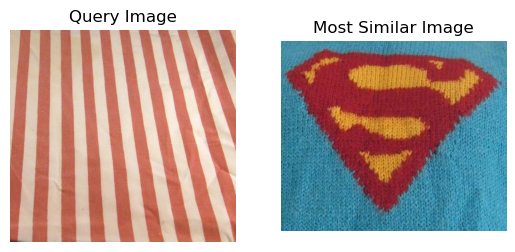

Precision at 1: 0
Precision at 10: 0.0


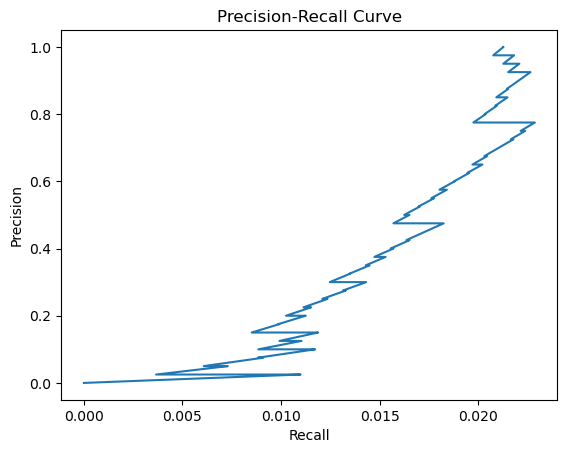

Retrieval time: 0.0 seconds


In [24]:
if __name__ == "__main__":
    main()

## 1. 2. DCT feature extractor

#### Overview:
The Discrete Cosine Transform (DCT) is a mathematical transformation commonly used in image processing for feature extraction. It represents an image in a frequency domain, capturing important patterns and structures. DCT is widely employed in various applications, including compression, image recognition, and similarity analysis.

#### Feature Extraction Process:

It initializes the class instance with a default value of 16 for the number of DCT coefficients. The number of coefficients is a parameter that determines how many low-frequency DCT coefficients will be extracted later.

##### DCT Calculation:
The DCT is applied to the image, transforming pixel values into a set of coefficients in the frequency domain.
DCT coefficients represent different frequency components, with lower-frequency components concentrated towards the top-left corner.

##### Feature Selection:
Low-frequency DCT coefficients, typically located in the top-left corner of the transformed image, are selected for feature extraction.
These coefficients capture the global structure and essential features of the image.

###### Flattening:
The selected DCT coefficients are flattened into a one-dimensional feature vector.
This feature vector represents the image in the frequency domain and serves as a concise representation of its important characteristics.

##### Normalization:
Z-score normalization is often applied to the feature vector to ensure consistent scales and enhance the interpretability of the extracted features.

In [25]:
class DCTImageDescriptor:
    def __init__(self, num_coefficients=16):
        # Initialize the class instance with the number of DCT coefficients
        self.num_coefficients = num_coefficients

    def extract_low_frequency_dct_features(self, image):
        
        """
        This method extracts low-frequency DCT (Discrete Cosine Transform) features from an input image.
        dct(image, axis=0, norm='ortho') computes the one-dimensional DCT along the rows of the image, 
        and dct(..., axis=1, norm='ortho') then computes the one-dimensional DCT along the columns of the intermediate result. 
        The resulting dct_image contains the two-dimensional DCT coefficients of the input image.
        
        norm='ortho': Specifies that orthogonalization should be applied during the transform. 
        The 'ortho' normalization ensures that the energy of the signal is preserved during the transform, making it unitary.
        
        indicates a special kind of normalization that ensures the energy (or overall strength) of the image is preserved 
        during the transformation. It's like adjusting the scale of the transformation 
        so that we maintain the important information in the image while using a consistent measure 
        for different frequencies. 
        """
        # Apply DCT to the entire image
        dct_image = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

        # Extract low-frequency DCT coefficients from the top-left
        low_frequency_dct = dct_image[:self.num_coefficients, :self.num_coefficients]

        # Flatten the coefficients
        feature_vector = low_frequency_dct.flatten()

        return feature_vector

    def normalize_feature_vector(self, feature_vector):
        # Apply Z-score normalization
        # Calculate the mean and standard deviation of the feature vector.
        mean = np.mean(feature_vector)
        std = np.std(feature_vector)
        normalized_feature_vector = (feature_vector - mean) / std

        return normalized_feature_vector

    def create_descriptor(self, image_path):
        # Load the image in grayscale
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Extract low-frequency DCT features
        feature_vector = self.extract_low_frequency_dct_features(image)

        # Normalize the feature vector
        normalized_feature_vector = self.normalize_feature_vector(feature_vector)

        return normalized_feature_vector

## Function: read_and_process_images

In [26]:
def read_and_process_images_dct(image_paths, dct_descriptor):
    # List to store image paths and corresponding DCT feature vectors
    dct_feature_vectors = []
    
    # Loop through each image path
    for image_path in image_paths:
        try:
            # Check if the image file has a valid extension
            if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Read the image in grayscale
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                # Check if the image loading was successful
                if image is None:
                    raise Exception(f"Error loading image: {image_path}")

                # Extract DCT features
                # Extract DCT features using the provided DCT descriptor
                # Calls the create_descriptor method of the provided dct_descriptor to extract DCT features from the image.
                dct_features = dct_descriptor.create_descriptor(image_path)

                # Append the image path and DCT feature vector to the list
                dct_feature_vectors.append((image_path, dct_features))

        except Exception as e:
            # Handle exceptions (e.g., image processing errors)
            print(f"Error processing image: {image_path}")
            print(e)
            continue
            
    # Return the list of image paths and corresponding DCT feature vectors
    return dct_feature_vectors

## Function: process_query_image

In [27]:
def process_query_image_dct(query_image_path, dct_descriptor, dct_feature_vectors):
    # Read the query image in grayscale
    query_image = cv2.imread(query_image_path, cv2.IMREAD_GRAYSCALE)

    # Extract DCT features for the query image
    # Extract DCT features for the query image using the provided DCT descriptor
    # Calls the create_descriptor method of the provided dct_descriptor to extract DCT features for the query image.
    query_dct_features = dct_descriptor.create_descriptor(query_image_path)

    # Dictionary to store distances between the query image and other images
    distances = {}
    # Loop through each image path and DCT feature vector in the precomputed collection
    for image_path, vector in dct_feature_vectors:
        # Calculate the Euclidean distance between DCT feature vectors
        euclidean_dist = euclidean(query_dct_features, vector)
        # Store the distance in the dictionary with the corresponding image path
        distances[image_path] = euclidean_dist

    return distances

## Function : load test images

In [28]:
def load_test_images(test_image_paths):
    # List to store test image paths
    test_images = []
    
    # Loop through each test image path
    for path in test_image_paths:
        # Construct the full image path using the specified folder and file path
        image_path = os.path.join(r'C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\images', path)
        
        # Using OpenCV to read the image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Append the full image path to the list
        test_images.append(image_path)
    return test_images

# Load test images
test_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\test1.txt"
test_image_paths = read_image_paths(test_file_path)
test_images = load_test_images(test_image_paths)

## Main function to execute the code

In [29]:
# Main function
def main():
    # Read train image paths from file
    train_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\train1.txt"
    train_image_paths = read_image_paths(train_file_path)

    # Load train images
    train_images = load_images(train_image_paths)
    
    # Assume 'test_images' is a list of test image paths loaded previously
    query_image_path = test_images[30]

    try:
        # Initialize DCT descriptor
        dct_descriptor = DCTImageDescriptor()
        dct_feature_vectors = read_and_process_images_dct(train_images, dct_descriptor)  # Process images for DCT feature extraction
        distances = process_query_image_dct(query_image_path, dct_descriptor, dct_feature_vectors)  # Process query image for DCT feature extraction


        # Retrieval time
        start_time = time.time()
        # Find the most similar image
        most_similar_image_dct = find_most_similar_image(distances)
        end_time = time.time()
        retrieval_time = end_time - start_time

        # Precision at 1
        relevant_images = [most_similar_image_dct]
        precision_at_1 = 1 if most_similar_image_dct == query_image_path else 0

        # Precision at 10
        top_10_images = [image for image, _ in sorted(distances.items(), key=lambda x: x[1])[:10]]
        precision_at_10 = top_10_images.count(query_image_path) / 10

        print(f"Most similar image (Euclidean distance): {most_similar_image_dct}")
        plot_most_similar_image(query_image_path, most_similar_image_dct)

        
        """
        if the most similar image has the same label but is not the exact same image (content-wise) as the query image, 
        precision_at_1 will still be set to 1.
        """
        print(f"Precision at 1: {precision_at_1}")
        
        
        """
        top_10_images: This list comprehension extracts the top 10 images from the sorted distances. 
        It sorts the items based on the second element of the tuple (the distance) and takes only the image paths.
        precision_at_10: This variable is calculated as the count of occurrences of the query image path 
        in the top 10 images divided by 10. It represents the fraction of the top 10 retrieved images that are relevant.


        precision_at_10 is a fraction indicating the proportion of the top 10 retrieved images that are relevant.
        """
        print(f"Precision at 10: {precision_at_10}")

        precision, recall = calculate_precision_recall(distances, query_image_path)
        # Plot the Precision-Recall curve
        plot_precision_recall_curve(precision, recall)

        print(f"Retrieval time: {retrieval_time} seconds")

    except Exception as e:
        print(f"An error occurred: {e}")



## Run the main function

Most similar image (Euclidean distance): C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\images\pitted\pitted_0040.jpg


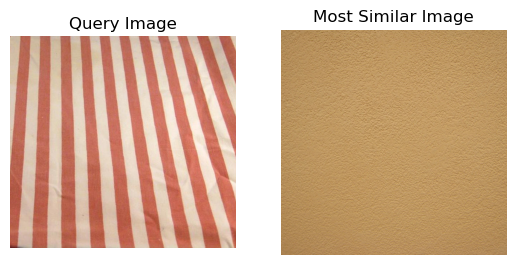

Precision at 1: 0
Precision at 10: 0.0


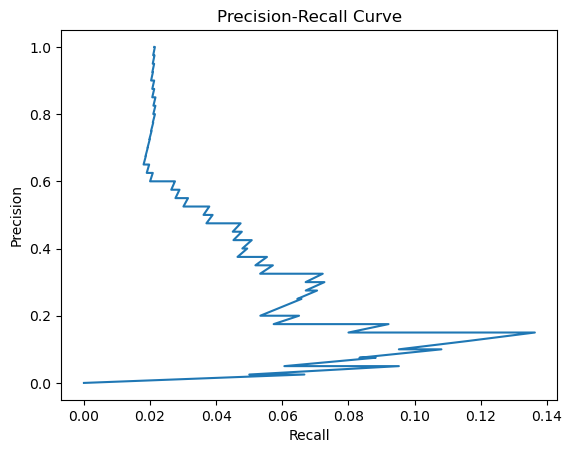

Retrieval time: 0.0 seconds


In [30]:
if __name__ == "__main__":
    main()

## 1. 3. GLCM

### Initialize a list to store feature vectors

In [31]:
list_of_glcm_feature_vectors = []

## Function : Calculate GLCM features for a grayscale image

###### 1. Introduction:
Purpose: GLCM is a technique used in image processing to capture spatial relationships between pixel intensities.
Objective: Extract features that describe texture and patterns within an image.

The input image (assumed to be in RGB format) to a grayscale image. Grayscale images are often used in texture analysis as the texture information is mainly present in the intensity variations of a single channel.

This step scales the pixel values of the grayscale image to the range [0, 255] and converts them to unsigned 8-bit integers. GLCM is typically calculated on images with pixel values in this range.

To make the GLCM features invariant to the scale of the image, each element in the resulting vector is divided by the Euclidean norm of the vector.

np.linalg.norm(glcm_vector): This expression calculates the Euclidean norm (magnitude) of the vector glcm_vector. The Euclidean norm is the square root of the sum of the squares of individual elements in the vector.

###### distances=[1]:
The distances parameter in the greycomatrix function determines the pixel pair distances for which the co-occurrence should be computed.
In this case, it is set to [1], which means it calculates the co-occurrence of pixel values that are separated by a distance of 1 pixel.
This implies that it is looking at neighboring pixels to see how often certain pixel pairs occur with a separation of 1 pixel. This is useful for capturing local spatial relationships in the image.

###### angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]:
The angles parameter specifies the angles at which the co-occurrence should be computed.
The values provided, [0, np.pi/4, np.pi/2, 3*np.pi/4], correspond to four directions: 0 degrees (horizontal), 45 degrees, 90 degrees (vertical), and 135 degrees.
These angles define the orientations along which the function will calculate the co-occurrence of pixel values. For example:
0 degrees corresponds to the horizontal direction.
45 degrees corresponds to a diagonal direction from the bottom-left to the top-right.
90 degrees corresponds to the vertical direction.
135 degrees corresponds to a diagonal direction from the bottom-right to the top-left.
Including multiple angles allows the GLCM to capture texture information in different directions in the image.
In summary, these parameters control how the GLCM is calculated by specifying the distances and angles at which the function examines the relationships between pixel values. This helps in capturing the spatial dependencies and texture patterns in different directions and distances within the image.


###### 2. Calculation of GLCM:
Matrix Creation: GLCM is computed based on the occurrence of pairs of pixel intensities at different spatial relationships (distances and angles).
Pairs: The co-occurrence of pixel pairs is examined to understand how often certain intensity combinations appear together.

###### 3. Parameters:
Distances: Specifies the pixel distances for which co-occurrence is calculated. Common values include 1, 2, or more.

Angles: Specifies the directions for which co-occurrence is calculated. Common angles are 0, 45, 90, and 135 degrees.

Symmetry: Determines whether the GLCM should be symmetric (considering the order of pixel pairs).

Normalization: Determines whether the GLCM should be normalized to facilitate comparison between images.

This line of code is using the greycomatrix function to calculate the Gray Level Co-occurrence Matrix (GLCM) for a given grayscale image. Here's a simplified explanation:

###### gray_image:
This is the grayscale version of the input image. The GLCM is calculated based on the pixel intensities in this image.

###### distances=[1]:
It means we're looking at pairs of pixels that are 1 step away from each other. We're examining the relationships between neighboring pixels.

###### angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]:
This parameter tells the function to look in four different directions when considering pixel pairs. The angles are specified in radians: 0 degrees (right), 45 degrees (up-right), 90 degrees (up), and 135 degrees (up-left).

###### symmetric=True:
This indicates that the GLCM should be symmetric. If pixel A and pixel B occur together often, it's considered the same as B and A occurring together often. This simplifies the matrix.

###### normed=True:
It means we want to normalize the GLCM. Normalization scales the values in the matrix so that they add up to 1. This makes it easier to compare GLCMs from different images.
In essence, this line of code is saying, "Calculate the GLCM for this grayscale image by looking at pairs of pixels that are 1 step away in four different directions. Make the matrix symmetric and normalize it." The resulting glcm variable will contain the GLCM matrix, which represents the spatial relationships of pixel intensities in the input grayscale image.

Here's a summary:

0 degrees (horizontal): This corresponds to the co-occurrence matrix calculated in the horizontal direction.

45 degrees (diagonal bottom-left to top-right): This corresponds to the co-occurrence matrix calculated in a diagonal direction from the bottom-left to the top-right.

90 degrees (vertical): This corresponds to the co-occurrence matrix calculated in the vertical direction.

135 degrees (diagonal bottom-right to top-left): This corresponds to the co-occurrence matrix calculated in a diagonal direction from the bottom-right to the top-left.


So, for each distance specified (in this case, distance [1]), you will get four co-occurrence matrices, each capturing the spatial relationships in a specific direction. These matrices collectively provide information about texture patterns in different orientations within the image.







In [32]:
def calculate_glcm(image):
    """
    Calculate GLCM features for a grayscale image.

    Parameters:
    - image: Input image for which GLCM features need to be calculated.

    Returns:
    - glcm_vector: Normalized 1D array of GLCM features.
    """
    
    """
    When performing texture analysis, it is common to work with grayscale images 
    because the texture characteristics are more pronounced in the intensity variations of a single channel.
    """
    # Step 1: Convert the input image to grayscale
    gray_image = color.rgb2gray(image)
    # Step 2: The pixel values of the grayscale image are scaled to the range [0, 255] and converted to unsigned 8-bit integers.
    #Ensure the image is in uint8 format
    gray_image = (gray_image * 255).astype(np.uint8)
    # Step 3: The GLCM is calculated using the greycomatrix function 
    # with specified distances, angles, symmetry, and normalization.
    glcm = greycomatrix(gray_image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    # # Step 4: Flatten the 2D GLCM matrix to a 1D array
    glcm_vector = glcm.flatten()
    # # Step 5: Normalize the GLCM vector by dividing each element by its Euclidean norm
    glcm_vector /= np.linalg.norm(glcm_vector)
    return glcm_vector


## Function : read and process images

In [33]:
def read_and_process_images_glcm(image_paths):
    """
    Read and process images, calculate GLCM features, normalize, and store the results.

    Parameters:
    - image_paths: List of file paths of images to be processed.
    - list_of_glcm_feature_vectors: List to store tuples of image path and corresponding normalized GLCM feature vector.
    """
    # Initialize an empty list to store tuples of image path and corresponding normalized GLCM feature vector
    glcm_feature_vectors = []
    # Loop through each image path
    for image_path in image_paths:
        try:
            # Check if the file has a valid image extension
            if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # Read the image using OpenCV
                image = cv2.imread(image_path)
                # Check if the image is successfully loaded
                if image is None:
                    raise Exception(f"Error loading image: {image_path}")
                    # Calculate GLCM features for the image
                glcm_vector = calculate_glcm(image)
                # Normalize the GLCM vector
                #normalized_vector = normalize(glcm_vector)
                # Append a tuple of image path and normalized GLCM vector to the result list
                glcm_feature_vectors.append((image_path, glcm_vector))
        except Exception as e:
            # Print an error message if there's an issue processing the image, and continue to the next image
            print(f"Error processing image: {image_path}")
            print(e)
            continue
    # Return the list of tuples, each containing the image path and the corresponding normalized GLCM feature vector
    list_of_glcm_feature_vectors.extend(glcm_feature_vectors)

## Function : read and process query image

In [34]:
def process_query_image_glcm(query_image_path):
    # Read the query image using OpenCV
    query_image = cv2.imread(query_image_path)
    # Calculate GLCM features for the query image
    glcm_vector = calculate_glcm(query_image)
    
    #normalized_vector = normalize(glcm_vector)
    
    # Create a dictionary to store distances between the query image and other images
    distances = {}
    # Loop through the list of GLCM feature vectors for comparison
    for image_path, vector in list_of_glcm_feature_vectors:
        # Calculate the Euclidean distance between the vectors
        euclidean_dist = euclidean_distance(vector, glcm_vector)
        # Store the distance in the dictionary with the image path as the key
        distances[image_path] = euclidean_dist
        
    # Return the dictionary of distances
    return distances

# Main function to execute the code

In [35]:
def main():
    # Specify the file path containing image labels for training
    train_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\train1.txt"
     # Read image paths from the training file
    train_image_paths = read_image_paths(train_file_path)

    # Load the training images
    train_images = load_images(train_image_paths)

    # Select a query image path for testing
    query_image_path = test_images[30]

    try:
        # Read and process training images to extract GLCM features
        read_and_process_images_glcm(train_images)
        
        # Process the query image using GLCM and find distances to training images
        distances = process_query_image_glcm(query_image_path)
        
        start_time = time.time()
        most_similar_image_glcm = find_most_similar_image(distances)
        end_time = time.time()
        retrieval_time = end_time - start_time
        
                
        """
        if the most similar image has the same label but is not the exact same image (content-wise) as the query image, 
        precision_at_1 will still be set to 1.
        """
        relevant_images = [most_similar_image_glcm]
        precision_at_1 = 1 if most_similar_image_glcm == query_image_path else 0

                
        """
        top_10_images: This list comprehension extracts the top 10 images from the sorted distances. 
        It sorts the items based on the second element of the tuple (the distance) and takes only the image paths.
        precision_at_10: This variable is calculated as the count of occurrences of the query image path 
        in the top 10 images divided by 10. It represents the fraction of the top 10 retrieved images that are relevant.


        precision_at_10 is a fraction indicating the proportion of the top 10 retrieved images that are relevant.
        """
        top_10_images = [image for image, _ in sorted(distances.items(), key=lambda x: x[1])[:10]]
        precision_at_10 = top_10_images.count(query_image_path) / 10
        
        print(f"Most similar image (Euclidean distance): {most_similar_image_glcm}")
        plot_most_similar_image(query_image_path, most_similar_image_glcm)

        
        print(f"Precision at 1: {precision_at_1}")
        
        print(f"Precision at 10: {precision_at_10}")

        precision, recall = calculate_precision_recall(distances, query_image_path)
        plot_precision_recall_curve(recall, precision)

        print(f"Retrieval time: {retrieval_time} seconds")
        

    except Exception as e:
        print(f"An error occurred: {e}")



## Run the main function 

Most similar image (Euclidean distance): C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\images\freckled\freckled_0088.jpg


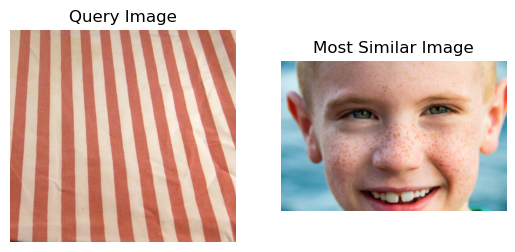

Precision at 1: 0
Precision at 10: 0.0


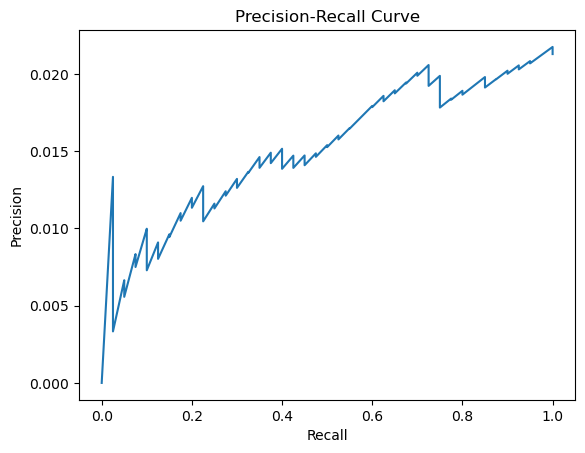

Retrieval time: 0.0032377243041992188 seconds


In [36]:
if __name__ == "__main__":
    main()

# 2. Deep Feature Extraction (1+ Features):

In [37]:
list_of_vgg16_features = []

### The layer for feature extraction

In [38]:
layer_name = 'block5_conv3'

### Function extract feature _vector

In [39]:
def extract_feature_vector(image_path, model, layer_name):
    # Load and preprocess the image
    # Load the image and resize it to (224, 224) pixels
    img = image.load_img(image_path, target_size=(224, 224))
    # Convert the image to a NumPy array
    x = image.img_to_array(img)
    # Add an extra dimension to create a batch of size 1     (matching the model's input format).
    x = np.expand_dims(x, axis=0)
    # Preprocess the input image for the VGG16 model
    # Preprocess the input image according to the requirements of the VGG16 model.
    x = preprocess_input(x)

    # Create a feature extraction model
    feature_extraction_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Extract the feature vector
    feature_vector = feature_extraction_model.predict(x)

    return feature_vector.flatten()

### Function : Apply PCA to a vector after normalizing it

In [40]:
def apply_pca2(vector):
    # Create a PCA object with 1 component
    pca = PCA(n_components=1)
    # Reshape the input vector to a column vector and perform PCA
    pca_components = pca.fit_transform(vector.reshape(-1, 1))
    # Flatten the result to a 1D array and return it
    return pca_components.flatten()

### Function read and process images vgg16

In [41]:
def read_and_process_images_vgg16(image_paths, model):
    # Initialize an empty list to store image path and PCA components tuples
    vgg16_features = []
    # Loop through each image path
    for image_path in image_paths:
        try:
            # Check if the file has a valid image extension
            if image_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                # read the image using OpenCV
                image = cv2.imread(image_path)
                # Check if the image is successfully loaded
                if image is None:
                    raise Exception(f"Error loading image: {image_path}")
                # Extract VGG16 feature vector
                feature_vector = extract_feature_vector(image_path, model, layer_name)
                # Normalize the feature vector
                normalized_vector = normalize(feature_vector.reshape(1, -1)).flatten()
                # Apply PCA to reduce dimensionality
                pca_components = apply_pca2(normalized_vector)
                # Append image path and PCA components to the list
                vgg16_features.append((image_path, pca_components))
                
        except Exception as e:
            # Handle exceptions (e.g., errors in image loading or feature extraction)
            print(f"Error processing image: {image_path}")
            print(e)
            continue   # Continue to the next image in case of an error

    list_of_vgg16_features.extend(vgg16_features)
    return vgg16_features

### Function : process query image vgg16

In [42]:
def process_query_image_vgg16(query_image_path, model):
    # Read the query image using OpenCV
    query_image = cv2.imread(query_image_path)
    # Extract VGG16 feature vector for the query image
    feature_vector = extract_feature_vector(query_image_path, model, layer_name)
    # Normalize the feature vector
    normalized_vector = normalize(feature_vector.reshape(1, -1)).flatten()
    # Apply PCA to reduce dimensionality
    pca_components = apply_pca2(normalized_vector)

    # Initialize an empty dictionary to store distances between the query image and other images
    distances = {}
    # Iterate through the list of VGG16 features (image paths and PCA components)
    for image_path, vector in list_of_vgg16_features:
        # Calculate Euclidean distance between the PCA components of the query image and the current image
        euclidean_dist = euclidean_distance(vector, pca_components)
        # Store the distance in the dictionary with the image path as the key
        distances[image_path] = euclidean_dist

    # Return the dictionary containing distances between the query image and other images
    return distances

## Main function to execute the code

In [43]:
def main():
    # Load the VGG16 model with pre-trained weights
    model = VGG16(weights='imagenet', include_top=False)

    # Define the file path containing training image labels
    train_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\train1.txt"
    # Read image paths from the training file
    train_image_paths = read_image_paths(train_file_path)
    # Load training images based on the paths
    train_images = load_images(train_image_paths)
    
    # Choose a query image path (e.g., the 30th image in the test set)
    query_image_path = test_images[30]

    try:
        # Read and process the training images using VGG16
        read_and_process_images_vgg16(train_images, model)
        # Process the query image and calculate distances
        distances = process_query_image_vgg16(query_image_path, model)

        # Measure retrieval time
        start_time = time.time()
        most_similar_image_vgg16 = find_most_similar_image(distances)
        end_time = time.time()
        retrieval_time = end_time - start_time
                
        """
        if the most similar image has the same label but is not the exact same image (content-wise) as the query image, 
        precision_at_1 will still be set to 1.
        """
        relevant_images = [most_similar_image_vgg16]
        precision_at_1 = 1 if most_similar_image_vgg16 == query_image_path else 0

        """
        top_10_images: This list comprehension extracts the top 10 images from the sorted distances. 
        It sorts the items based on the second element of the tuple (the distance) and takes only the image paths.
        precision_at_10: This variable is calculated as the count of occurrences of the query image path 
        in the top 10 images divided by 10. It represents the fraction of the top 10 retrieved images that are relevant.


        precision_at_10 is a fraction indicating the proportion of the top 10 retrieved images that are relevant.
        """
        top_10_images = [image for image, _ in sorted(distances.items(), key=lambda x: x[1])[:10]]
        precision_at_10 = top_10_images.count(query_image_path) / 10

        print(f"Most similar image (Euclidean distance): {most_similar_image_vgg16}")
        plot_most_similar_image(query_image_path, most_similar_image_vgg16)

        print(f"Precision at 1: {precision_at_1}")
        print(f"Precision at 10: {precision_at_10}")

        precision, recall = calculate_precision_recall(distances, query_image_path)
        plot_precision_recall_curve(recall, precision)

        print(f"Retrieval time: {retrieval_time} seconds")

    except Exception as e:
        print(f"An error occurred: {e}")


## Run the Main function

1/1 [==============================] - 1s 607ms/step
Most similar image (Euclidean distance): C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\images\banded\banded_0045.jpg


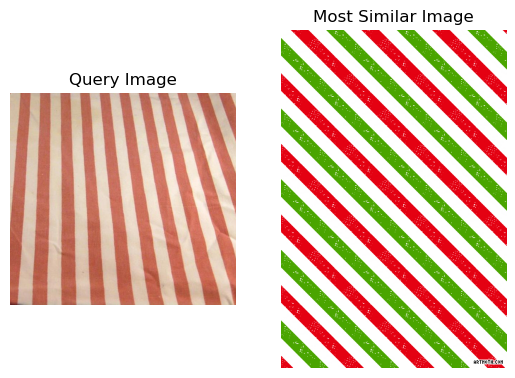

Precision at 1: 0
Precision at 10: 0.0


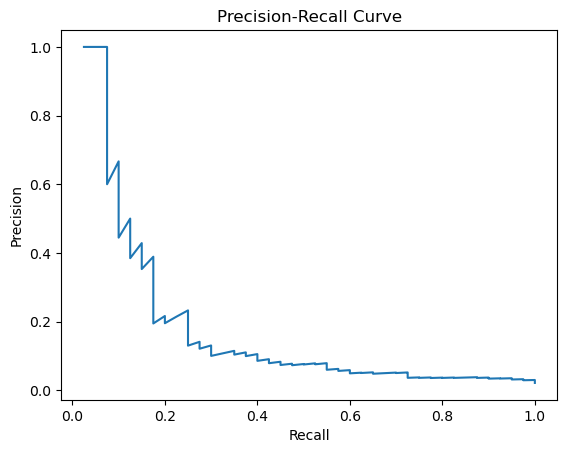

Retrieval time: 0.0009982585906982422 seconds


In [44]:
if __name__ == "__main__":
    main()

# Feature Combination:
## Function: combine_features_with_pca for the combined features

This function essentially combines feature vectors from two lists, performs dimensionality reduction using PCA, and returns a list of PCA-transformed combined feature vectors.

In [45]:
def combine_features_with_pca(feature_vectors_list1, feature_vectors_list2):
    # Initialize an empty list to store the combined and PCA-transformed features
    combined_features = []
    # Iterate through corresponding feature vectors in the two lists
    for feature_vector1, feature_vector2 in zip(feature_vectors_list1, feature_vectors_list2):
        # Concatenate the feature vectors element-wise
        concatenated_vector = np.concatenate((feature_vector1, feature_vector2))

        # Apply PCA on the combined feature vector
        pca_combined = PCA(n_components=1)
        pca_components_combined = pca_combined.fit_transform(np.array([concatenated_vector]))
        pca_vector_combined = pca_components_combined.flatten()

        # Append the PCA-transformed combined feature vector to the list
        combined_features.append(pca_vector_combined)

    return combined_features

###### Combining two sets of feature vectors, list_of_glcm_feature_vectors and list_of_vgg16_features, into a tuple named combined_feature_vectors.

In [46]:
combined_feature_vectors = (list_of_glcm_feature_vectors, list_of_vgg16_features)

In [47]:
def process_query_image_combined(query_image_path, model, combined_feature_vectors):
    # Read the query image
    query_image = cv2.imread(query_image_path)

    # GLCM feature extraction for the query image
    glcm_vector = calculate_glcm(query_image)
    normalized_glcm_vector = normalize(glcm_vector)

    # VGG16 feature extraction for the query image
    vgg16_feature_vector = extract_feature_vector(query_image_path, model, layer_name)
    normalized_vgg16_vector = normalize(vgg16_feature_vector.reshape(1, -1)).flatten()

    # Combine features for the query image
    pca_combined_vector = combine_features_with_pca([normalized_glcm_vector], [normalized_vgg16_vector])[0]

    # Calculate distances
    distances = {}
    # Iterate through the combined feature vectors
    for (glcm_image_path, glcm_vector), (vgg16_image_path, vgg16_vector) in zip(*combined_feature_vectors):
        # Concatenate GLCM and VGG16 vectors and calculate Euclidean distance
        euclidean_dist = euclidean_distance(np.concatenate((glcm_vector, vgg16_vector)), pca_combined_vector)
        # Store the distance in the dictionary with the GLCM image path as the key
        distances[glcm_image_path] = euclidean_dist

    return distances

# Main function to execute the code

In [48]:
def main_combined():
    # Load the VGG16 model with pre-trained weights
    model = VGG16(weights='imagenet', include_top=False)
    

    # Define the file path containing training image labels
    train_file_path = r"C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\labels\train1.txt"
    # Read image paths from the training file
    train_image_paths = read_image_paths(train_file_path)
    # Load training images based on the paths
    train_images = load_images(train_image_paths)

    # Choose a query image path (e.g., the 30th image in the test set)
    query_image_path = test_images[30]

    try:

        # Combined feature extraction for the entire dataset
        distances_combined = process_query_image_combined(query_image_path, model, combined_feature_vectors)

         # Measure retrieval time
        start_time = time.time()
        most_similar_image_combined = find_most_similar_image(distances_combined)
        end_time = time.time()
        retrieval_time = end_time - start_time
                
        """
        if the most similar image has the same label but is not the exact same image (content-wise) as the query image, 
        precision_at_1 will still be set to 1.
        """        

        """
        top_10_images: This list comprehension extracts the top 10 images from the sorted distances. 
        It sorts the items based on the second element of the tuple (the distance) and takes only the image paths.
        precision_at_10: This variable is calculated as the count of occurrences of the query image path 
        in the top 10 images divided by 10. It represents the fraction of the top 10 retrieved images that are relevant.


        precision_at_10 is a fraction indicating the proportion of the top 10 retrieved images that are relevant.
        """
        # Evaluate precision at 1 and precision at 10
        relevant_images_combined = [most_similar_image_combined]
        precision_at_1_combined = 1 if most_similar_image_combined == query_image_path else 0

        top_10_images_combined = [image for image, _ in sorted(distances_combined.items(), key=lambda x: x[1])[:10]]
        precision_at_10_combined = top_10_images_combined.count(query_image_path) / 10

        print(f"Most similar image (Euclidean distance) - Combined: {most_similar_image_combined}")
        plot_most_similar_image(query_image_path, most_similar_image_combined)

        print(f"Precision at 1 - Combined: {precision_at_1_combined}")
        print(f"Precision at 10 - Combined: {precision_at_10_combined}")

        precision_combined, recall_combined = calculate_precision_recall(distances_combined, query_image_path)
        plot_precision_recall_curve(recall_combined, precision_combined)

        print(f"Retrieval time - Combined: {retrieval_time} seconds")

    except Exception as e:
        print(f"An error occurred: {e}")


# Run the Main function

1/1 [==============================] - 1s 824ms/step
Most similar image (Euclidean distance) - Combined: C:\Users\Magda\Documents\Term 7\Computer Vision\7th mini project\dtd-r1.0.1\dtd\images\perforated\perforated_0068.jpg


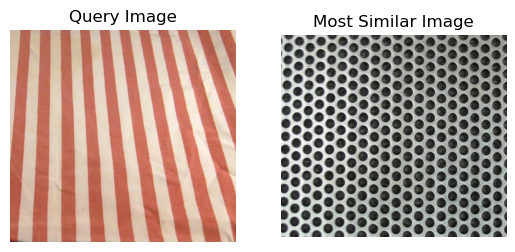

Precision at 1 - Combined: 0
Precision at 10 - Combined: 0.0


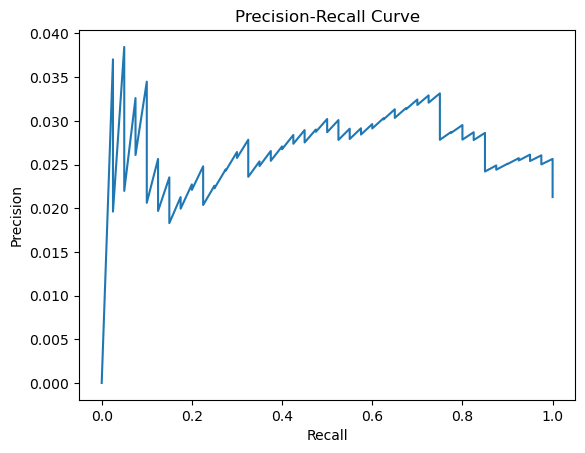

Retrieval time - Combined: 0.004541873931884766 seconds


In [49]:
if __name__ == "__main__":
    main_combined()
